In [1]:
from dataloader import *
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2 as cv # so annoying in tutorials ngl
import random
%matplotlib qt
from skimage import data, feature, exposure
import pytesseract
from docx import Document

In [2]:
files = DataAnuncis('/home/adri/Desktop/cvc/data/tinder-historic/filenames.txt')


In [5]:
sample = files[2]

In [4]:
plt.imshow(sample, cmap = 'gray')
plt.show()


In [5]:
sample = files[2] # Takes the groundtruth

In [6]:
plt.imshow(sample, cmap = 'gray')
plt.show()


In [7]:
ret, thresh = cv2.threshold(sample, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)


In [8]:
plt.imshow(thresh, cmap = 'gray')
plt.show()

In [9]:
cols = thresh.shape[1]
horizontal_size = cols // 30
horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_size, 1))
horizontal = cv2.erode(thresh, horizontalStructure)
horizontal = cv2.dilate(horizontal, horizontalStructure)

In [10]:
# Specify size on vertical axis
rows = thresh.shape[0]
verticalsize = rows // 30
# Create structure element for extracting vertical lines through morphology operations
verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1, verticalsize))
# Apply morphology operations
vertical = cv2.erode(thresh, verticalStructure)
vertical = cv2.dilate(vertical, verticalStructure)

In [11]:
%matplotlib qt
plt.imshow(vertical*.5 + horizontal*.5, cmap = 'gray')
plt.show()

In [12]:
anuncis = vertical*.7 + horizontal*.3 # What will we do when the blocks arent delimited by lines
anuncis = ((anuncis - anuncis.min()) / (anuncis.max() - anuncis.min())) * 255
ret, anuncis = cv2.threshold(anuncis.astype(np.uint8), 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
plt.imshow(anuncis, cmap = 'gray')
plt.show()

In [13]:
anuncis = ~ anuncis
plt.imshow(anuncis, cmap = 'gray')
plt.axis('off')
plt.show()


In [14]:
lines = cv.HoughLinesP(anuncis, 1, np.pi / 180, 150, 10, None)

In [15]:
src = np.zeros_like(sample)
for i in range(0, len(lines)):
    l = lines[i][0]
    src = cv.line(src, (l[0], l[1]), (l[2], l[3]), (155,155,255), 3, cv.LINE_AA)

In [16]:
plt.imshow(src, cmap = 'gray')
plt.axis('off')
plt.show()

In [17]:
contours, hierarchy = cv2.findContours(anuncis, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))

398


In [18]:
sample2 = np.zeros_like(sample.copy())
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    # Drawing a rectangle on copied image
    sample2 = cv2.rectangle(sample2, (x, y), (x + w, y + h), (255, 255, 255), 2)

In [19]:
plt.imshow(sample2*0.8 + sample*0.2, cmap = 'gray')
plt.show()

In [20]:
dilation = cv2.dilate(anuncis,np.ones((5, 5)),iterations = 5)

In [21]:
plt.imshow(~dilation, cmap = 'gray')
plt.show()

In [22]:
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))

99


In [23]:
sample2 = np.zeros_like(sample.copy())
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    # Drawing a rectangle on copied image
    sample2 = cv2.rectangle(sample2, (x, y), (x + w, y + h), (255, 255, 255), 2)

In [24]:
plt.imshow(sample2*0.8 + sample*0.2, cmap = 'gray')
plt.axis('off')
plt.show()

In [25]:
img = sample2*0.8 + sample*0.2
img = ((img - img.min())/(img.max() - img.min()))*255
cv2.imwrite('res1.png', img.astype(np.uint8))

True

In [26]:
def get_boxes(sample, prop_vertical = 0.7, iter_dilate = 5, dilate_size = 4):
    
    
    ret, thresh = cv2.threshold(sample, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    cols = thresh.shape[1]
    horizontal_size = cols // 30
    horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_size, 1))
    horizontal = cv2.erode(thresh, horizontalStructure)
    horizontal = cv2.dilate(horizontal, horizontalStructure)

    # Specify size on vertical axis
    rows = thresh.shape[0]
    verticalsize = rows // 30
    # Create structure element for extracting vertical lines through morphology operations
    verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1, verticalsize))
    # Apply morphology operations
    vertical = cv2.erode(thresh, verticalStructure)
    vertical = cv2.dilate(vertical, verticalStructure)
    
    anuncis = vertical*prop_vertical + horizontal*(1 - prop_vertical) # What will we do when the blocks arent delimited by lines
    anuncis = ((anuncis - anuncis.min()) / (anuncis.max() - anuncis.min())) * 255
    ret, anuncis = cv2.threshold(anuncis.astype(np.uint8), 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    anuncis = ~ anuncis
    
    
    dilation = cv2.dilate(anuncis,np.ones((dilate_size, dilate_size)),iterations = iter_dilate)
    
    
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    sample2 = np.zeros_like(sample.copy())
    bbxs = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if 1: #w/h < 5 and w/h > 1:
            bbxs.append((x, y, w, h))
            # Drawing a rectangle on copied image
            # We need a discard criteria
            sample2 = cv2.rectangle(sample2, (x, y), (x + w, y + h), (255, 255, 255), 2)


    img = sample2*0.8 + sample*0.2
    img = ((img - img.min())/(img.max() - img.min()))*255

    return img, bbxs

In [27]:
img, bxs = get_boxes(sample)
plt.imshow(img)
plt.show()

In [28]:
img, bxs = get_boxes(files[2])
plt.imshow(img)
plt.show()

#### Detect titles with blops

In [29]:
def find_blblurred(sample, blur_size = 11, conv_kernel = np.array([[0, 1, 0], [0, 1, 0], [0, 1, 0]]), erosion_size = 5, erosion_iter = 1, ret_boxes = False):
    
    ret, thresh = cv2.threshold(sample, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    blurred = cv2.GaussianBlur(thresh, (blur_size, blur_size), 10)
    #blurred = cv2.Canny(thresh, 0, 100)
    kernel = conv_kernel
    kernel2 = kernel.T

    convolved = cv2.filter2D(blurred, -1, kernel = kernel) + cv2.filter2D(blurred, -1, kernel = kernel2)
    erosion = cv2.erode(convolved,np.ones(erosion_size),iterations = erosion_iter)
    ret, thresh = cv2.threshold(erosion, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(~thresh)


    # Map component labels to hue val, 0-179 is the hue range in OpenCV
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # Converting cvt to BGR
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_BGR2RGB)
    output = np.zeros_like(sample).copy()

    boxes = []
    for i in range(0, num_labels):

        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        (cX, cY) = centroids[i]
        if w*h < 1e4 or w/h < 1e-2 or h/w < 1e-2: continue # Hardcoded, do it from histogram
        
        
        output = cv2.rectangle(output, (x, y), (x + w, y + h), (255, 255, 255), 3)
        boxes.append((x, y, w, h))
    
    if ret_boxes: return output, boxes
    return output

    

In [30]:
plt.imshow(find_blblurred(sample) + get_boxes(sample)[0], cmap = 'gray')
plt.axis('off')
plt.show()

In [31]:
plt.imshow(find_blblurred(sample, blur_size = 11, erosion_size=5, erosion_iter=1), cmap = 'gray')
plt.axis('off')
plt.show()

In [32]:
stats = []
for i in range(30):
    print(i, end = '\r')
    s = files[i]
    _, bbox = find_blblurred(s, ret_boxes=1)
    for w in bbox:
        stats.append([w[2]/w[3], w[2] * w[3]])
    

In [33]:
ratio, area = ([i[0] for i in stats], [i[1] for i in stats])

In [34]:
freqs, bins = np.histogram(ratio)

In [35]:
freqs, bins

(array([3991,   13,   18,    6,    9,    6,    7,    1,    1,    1]),
 array([1.00154083e-02, 7.46553561e+00, 1.49210558e+01, 2.23765760e+01,
        2.98320962e+01, 3.72876164e+01, 4.47431366e+01, 5.21986568e+01,
        5.96541770e+01, 6.71096972e+01, 7.45652174e+01]))

In [36]:
i = 100
plt.imshow(find_blblurred(files[i]) + get_boxes(files[i])[0], cmap = 'gray')
plt.show()

## Other stuff

In [3]:
def corner_detector(sample):
    ret, thresh = cv2.threshold(sample, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    dst = cv.cornerHarris(thresh,10,3,0.04)
    #ret, thresh = cv2.threshold(dst, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    dst = (dst - dst.min()) / (dst.max() - dst.min()) * 255
    ret, thresh = cv2.threshold(dst.astype(np.uint8), 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    
    thresh = ~thresh
    conv_kernel = np.array([[0, 1, 0], [0, 1, 0], [0, 1, 0]])
    kernel = conv_kernel
    kernel2 = kernel.T
    convolved = cv2.filter2D(thresh, -1, kernel = kernel) + cv2.filter2D(thresh, -1, kernel = kernel2)
    
    
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(convolved)


    # Map component labels to hue val, 0-179 is the hue range in OpenCV
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # Converting cvt to BGR
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_BGR2RGB)

    output = np.zeros_like(sample).copy()
    outputFilled = np.zeros_like(sample).copy()

    boxes = []
    for i in range(0, num_labels):

        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        (cX, cY) = centroids[i]
        if h*w < 1000 or h*w > 0.9*sample.shape[-1] * sample.shape[-2]: continue
        
        
        outputFilled = cv2.rectangle(outputFilled, (x, y), (x + w, y + h), ((255, 255, 255)), -1)
        output = cv2.rectangle(output, (x, y), (x + w, y + h), (255, 255, 255), 10)
        
        boxes.append((x, y, w, h))
    
    ### CONVEX HULL ###
    ret = cv.findContours((outputFilled).astype(np.uint8), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    drawing = np.zeros_like(sample).copy()

    color = (random.randint(50,255), random.randint(50,255), random.randint(50,255))
    
    return output, labeled_img, boxes, convolved, outputFilled

    

In [6]:
o, i, bbxs, c, filled = corner_detector(sample)

In [7]:
plt.imshow(i.astype(np.uint8)/255 * 0.5 + np.stack((sample, sample, sample)).transpose(1, 2, 0)/255 * 0.5)
plt.show()

In [40]:
fig, axs = plt.subplots(1, 4, figsize = ( 32, 8 ))

axs[3].imshow(filled, cmap = 'gray')
axs[3].axis('off')

axs[2].imshow(i.astype(np.uint8)/255 * 0.3 + np.stack((o, o, o)).transpose(1, 2, 0)/255 * 0.7)
axs[2].axis('off')

axs[1].imshow(c, cmap = 'gray')
axs[1].axis('off')

axs[0].imshow(sample, cmap = 'gray')
axs[0].axis('off')

plt.show()

In [8]:
def visualize_sample(index, files = files):
    o, i, bbxs, c, filled = corner_detector(files[index])
    fig, axs = plt.subplots(1, 4, figsize = ( 32, 8 ))
    
    axs[3].imshow(files[index]*.5 + filled*.5, cmap = 'gray')
    axs[3].axis('off')
    
    axs[2].imshow(i.astype(np.uint8)/255 * 0.3 + np.stack((o, o, o)).transpose(1, 2, 0)/255 * 0.7)
    axs[2].axis('off')

    axs[1].imshow(c, cmap = 'gray')
    axs[1].axis('off')

    axs[0].imshow(files[index], cmap = 'gray')
    axs[0].axis('off')

    plt.show()


In [9]:
visualize_sample(42)

In [10]:
def extract_boxes(img, filled_image):
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(filled_image)
    boxes = []
    output = np.zeros_like(sample).copy()
    for i in range(0, num_labels):

        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        (cX, cY) = centroids[i]
        if h*w > 0.8*sample.shape[-1] * sample.shape[-2]: continue
        
        output = cv2.rectangle(output, (x, y), (x + w, y + h), (255, 255, 255), 10)
        boxes.append(img[y:y+h, x:x+w])
        
    # Map component labels to hue val, 0-179 is the hue range in OpenCV
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # Converting cvt to BGR
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_BGR2RGB)
        
    return boxes, output, labeled_img

In [44]:
plt.imshow(extract_boxes(sample, filled)[2])
plt.show()

In [45]:
bbxs, out, labeled = extract_boxes(files[300], corner_detector(files[300])[-1])

In [46]:
plt.imshow(out)
plt.show()

In [47]:
rows, cols = len(bbxs) // 10, 10

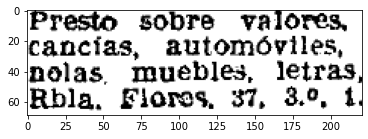

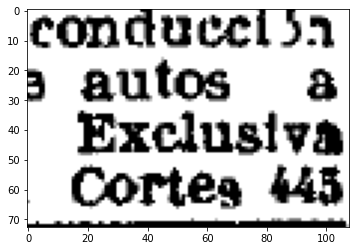

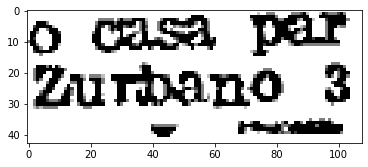

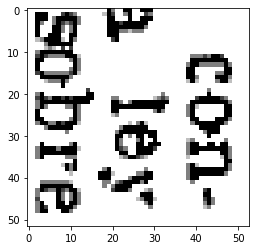

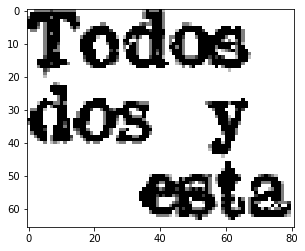

In [48]:
%matplotlib inline
random.shuffle(bbxs)
for i in bbxs[:5]:
    plt.imshow(i, cmap = 'gray')
    plt.show()



%matplotlib qt

In [ ]:
#pytesseract.get_languages()
#all_strings =  [[pytesseract.image_to_string(i, lang = 'spa', nice = 10) for i in bbxs] for bbxs, _, _ in [extract_boxes(files[i], corner_detector(files[i])[-1]) for i in range(len(files))]]

all_strings = []
for i in range(len(files)):
    bbxs, _, _ = extract_boxes(files[i], corner_detector(files[i])[-1])
    this_document = []
    print(f"Doing document {i}", end = '\n')
    for n, bbx in enumerate(bbxs):
        print(f"Doing bbx {n}", end = '\r')
        this_document.append(pytesseract.image_to_string(bbx, lang = 'spa', nice = 10))
    all_strings.append(this_document)
        

mas



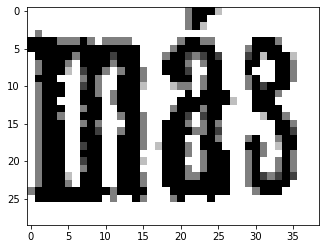

oras
San An-



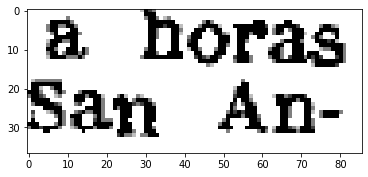

completamente libre Se ore
ce a servir a persona sola,
con buenas referencias. Es
cribir Tiroleses, MM.  Pe-

 



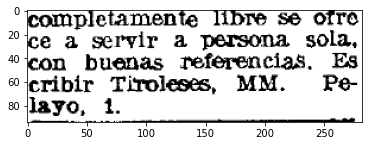

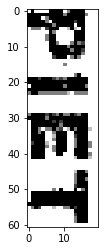

so olmeca para
dencia trancesa.

 



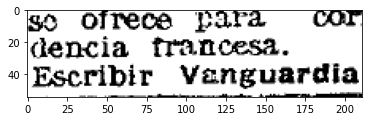

In [50]:
%matplotlib inline
random.shuffle(bbxs)
#strings = [pytesseract.image_to_string(i) for i in bbxs]
for n, i in enumerate(bbxs[:5]):
    plt.imshow(i, cmap = 'gray')
    print(pytesseract.image_to_string(i, lang = 'spa', nice = 10))
    plt.show()



%matplotlib qt

In [11]:
gt_transcriptions = [Document('La Vanguardia 1905.docx'), Document('La Vanguardia Enero 1910 .docx'), Document('La Vanguardia Febrero 1910.docx'),  Document('La Vanguardia Marzo 1910.docx'), Document('La Vanguardia Abril 1910.docx')]

In [58]:
#all_strings = [pyteDocumentract.image_to_string(i, lang = 'spa', nice = 10) for i in [extract_boxes(files[j], corner_detector(files[j])[-1])[0] for j in range(len(files)) ]]

In [12]:
paragraphs = [[x.text for x in w.paragraphs] for w in gt_transcriptions]

In [13]:
missatge = ''
announcments = []
hold = True
for par in paragraphs:
    for p in par:
        if not len(p): hold = False
        if hold: missatge += ' ' + p
        else:
            if len(missatge) and not '.pdf' in missatge:
                announcments.append(missatge.replace('- ', ''))
            hold = True
            missatge = ''

    
        
    

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [21]:
token = TfidfVectorizer()
transforms = token.fit_transform(announcments)

In [27]:
#token.get_feature_names()

In [37]:
from sklearn.cluster import AgglomerativeClustering

In [38]:
ms = AgglomerativeClustering()
categories = ms.fit_predict(transforms.toarray())

In [39]:
categories

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [40]:
from sklearn.decomposition import PCA

In [41]:
reduced = PCA(2).fit_transform(transforms.toarray())

In [43]:
plt.scatter(reduced[:, 0], reduced[:, 1])
plt.show()

In [45]:
token.transform(["Esto es un texto de ejemplo"]).toarray()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  